# Evaluación y Uso de YOLO-base para detección de pólipos

## Introducción

En este notebook, exploramos y evaluamos el rendimiento del modelo [**YOLO-base 2017**](https://huggingface.co/hustvl/yolos-base)
para la detección de pólipos cancerosos en imágen médica de colonoscopias.

Para ello utilizaremos el dataset de [**Piccolo**](https://huggingface.co/hustvl/yolos-base) combinado en entrenamiento con el dataset [CVC](https://polyp.grand-challenge.org/CVCClinicDB/),
este conjunto de datasets proporciona imágenes de colonoscopias tanto en RGB como en NBI,
y combinar ambos en entrenamiento nos dará mas variedad y cacapidad de generalización.
Para la detección **modificaremos el modelo** el modelo para detectar los pólipos
usando bboxes.

### Objetivos

- Modificar el modelo **YOLO-base 2017** para la detección de pópipos con bounding boxes.
- Entrenar el modelo con las imágenes medicas seleccionadas haciendo un **fine-tunning** para imágen médica.
- Mostar el rendimiento del mismo con el benchamark del modelo seleccionado

¡Comencemos con la evaluación del modelo!
## Pasos a seguir

1. Cargamos y analizamos los **datasets**
2. **Procesamos los datos** para cumplir con el formato de entrada del modelo
3. Cargamos y **modificamos el modelo** para detección de pólipos
4. **Entrenamos** el modelo con los datos obtenidos
4. **Evaluamos** el rendimiento

### 1- Cargar y analizar el dataset

Como hemos mencionado cargaremos el datset de [**Piccolo**](https://www.biobancovasco.bioef.eus/en/Sample-and-data-catalog/Databases/PD178-PICCOLO-EN.html),
el cuál tiene una cantidad rezonable de imágenes en RGB y NBI categorizadas por 
al pólipo al que pertenecen por lo que podemos usar la división pre hecha del dataset
y evitar asignar frames del mismo pólipo al train y validation invalidando los relustados.

Además usaremos el dataset [CVC](https://polyp.grand-challenge.org/CVCClinicDB/)
para enriquecer a Piccolo en entrenamiento y evitar que generalice mal

Además mostraré informaciñon relevante de las imágenes escogidas

In [66]:
import sys
import os
path_to_add = os.path.abspath('../../utils')
if path_to_add not in sys.path:
    sys.path.append(path_to_add)
from utils import ImageDatasetProcessor as idp
import os

DS_PATH = "../../datasets"
DS_NAME = "Piccolo+CVC"
json_path = f"{DS_PATH}/piccolo_dataset/{DS_NAME}_dict.json"

# paths del dataset
paths_img = [
    # test paths
    (DS_PATH + "/piccolo_dataset/test/polyps",                      # polyps
     DS_PATH + "/piccolo_dataset/test/masks",                       # masks
     DS_PATH + "/piccolo_dataset/test/void", "test"  ,              # voids
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),      # light type

    # train paths
    (DS_PATH + "/piccolo_dataset/train/polyps",
     DS_PATH + "/piccolo_dataset/train/masks",
     DS_PATH + "/piccolo_dataset/train/void", "train",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),

    # cvc train path
    (DS_PATH + "/CVC-ClinicDB/polyps", 
     DS_PATH + "/CVC-ClinicDB/masks",
     None, "train", None),

    # validation paths
    (DS_PATH + "/piccolo_dataset/validation/polyps",
     DS_PATH + "/piccolo_dataset/validation/masks",
     DS_PATH + "/piccolo_dataset/validation/void", "validation",
     DS_PATH + "/piccolo_dataset/listado_WL-NBI_Piccolo.csv")]

# inicializamos el dataset con su nombre y fichero de formatos de imagen
dt_picc_cvc = idp(target_resolution=(384, 288), dataset_name=DS_NAME,
                     json_path=json_path)

# procesamos el dataset si no existe el json
if not os.path.isfile(json_path):
    for path in paths_img:
        print(f"procesando conjunto: {path[3]}")
        dt_picc_cvc.load_dataset(path[0], path[1], voids_path=path[2], 
                                split=path[3], light_csv=path[4])

#### Análisis del dataset
Como podemos ver es un dataset muy ordenado, con una cantidad representativa de
imágenes NBI por lo que es adecuado para el entrenamiento en ambos tipos de luz 
(WL, NBI).

Además podemos observar que es un dataset con una distribución de los pólipos
más o menos descentralizada. Y señalar que usaremos la división del propio dataset,
 es decir, usaremos el split base de train, test y validation ya que este es 
 **distribuye los pólipos** no las imagenes aleatoriamente,
 **evitando tener imágenes del mismo pólipo en train y validation**, añadiremos 
 al conjunto base de train las imágenes del dataset CVC

In [67]:
dt_picc_cvc.print_summary()

Total imágenes: 4045
Composición del dataset:
Resoluciónes: total distintas resoluciones 3
	480x854: 1972	1080x1920: 1461	288x384: 612

Tipos de luz:
	WL: 2131	NBI: 1302	Unknown: 612

Splits:
	test: 333	train: 2815	validation: 897

Canales:
	polyp_RGB: 4045	mask_L: 4045	void_L: 3433

Volumen medio de los pólipos respecto a la imagen:	18.52638097233012%
Distancia media del centro del pólipos al centro de la imagen:	60.29317555516509px


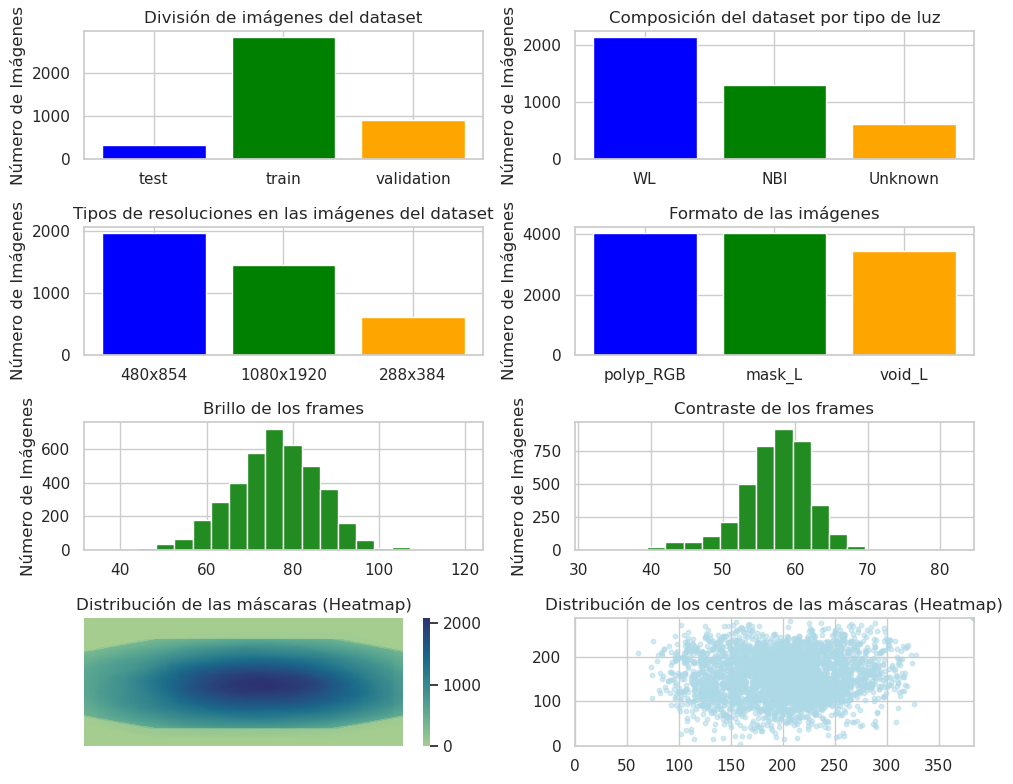

In [68]:
dt_picc_cvc.graph_summmary()

Finalmente veamos una muestra de una imágen aleatoria y su aspecto con la bbox

Imagen 059_VP17_frame1860.png	bbox: (390, 99, 280, 373)


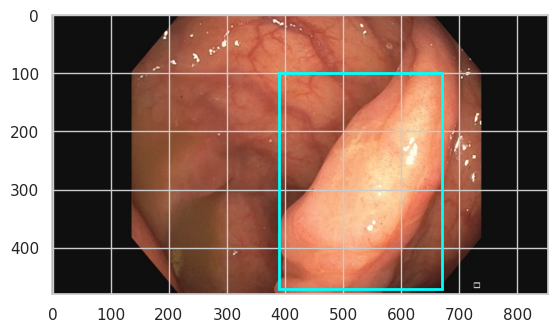

In [69]:
import random

# mostramos aleatoriamente una imágen del dataset
rand_key = random.choice(list(dt_picc_cvc.dict.keys()))
dt_picc_cvc.show_image(rand_key)


## Entrenamiento de YOLO

Para esta segunda entrenaremos el modelo de [yolos-base](https://huggingface.co/hustvl/yolos-base)
con las imágenes del dataset de Piccolo, con la peculiaridad que trataremos con 
un modelo modificado para devolver solo las bboxes.

#### Pasos del entrenemiento
1. **Modificaremos el modelo** para entrenar y devolver tan solo las bboxes ya que 
YOLO tiene dos MLP de salida que recogen los mismos datos del encoder, estas
son las **dos salidas de yolo** que son el clasificador de clases de COCO y las
bbox que localizan este objeto, **solo nos interesa la segunda**

2. **Preparar todo para el entrenamiento**, esto son elementos como el 
optimizador y la función de pérdida además de juntar definitivamente los datos
en los splits adecuados y DataLoaders para usarlos en la función de entrenamiento

3. **Entrenar** el modelo y ir obteniendo datos del rendimiento del mismo para
poder mostrarlos más adelante

### Modificar el modelo para Fine-Tunning
Tenemos un modelo de **yolos-base** con una arquitectura ViT y la salida del decoder
se da a dos MLP aisladas, estas son las dos salidas:

1. MLP de dos capas con una salida de claisificacion de 92 clases de COCO
2. MLP de dos capas pero la salida es un vector de 4 elementos con las coordenadas
en formato "center" o YOLO de la bbox **(cx,cy,w,h)**

En ambos casos el modelo de **Yolo hará 100 predicciones** de cajas y de clases.

Como queremos simplemente una prediccion de bbox, debemos hacer dos cosas
- Congelar la MLP correspondiente a la clasificacion de COCO ya que **solo queremos la obtención de las bboxes** con las que detectamos los pólipos.
- Reemplazara la capa de detección de bboxes por una que solo obtenga 1 prediccion
haciendo el modelo **más eficiente y sencillo**. Algo que puede ayudar debido a
la baja variabilidad de las imágenes de pólipos que son muy parecidas entre si.

Ya que estamos creando una nueva cabeza de predicción en para el modelo de yolos,
 congeelamos el modelo para **hacer un fine tunning de esta última capa** y ver que 
 tal funciona.

Para ello crearemos una clase con el modelo de Yolos personalizado como indica 
la [documentación de hugging face](https://huggingface.co/docs/transformers/custom_models).
y en ella personalizaremos las siguientes preferencias:
- **Eliminar class_labels_classifier**: Se borra y se reemplaza por None.
- El **forward() solo devuelve las bboxes**: Se quita la salida de clasificación.
- El modelo ahora **solo hace backpropagation en las bounding boxes**

In [70]:
from transformers import YolosForObjectDetection
import torch.nn as nn
import torch

# Heredamos el modelo de YolosForObjectDetection
class YolosBBoxOnly(YolosForObjectDetection):
    # Usamos el constructor original pero eliminando la MLP de clasificación
    # Esto evita que el modelo actualize en el backward esa MLP
    def __init__(self, config):
        super().__init__(config)

        # Congelamos las capas del clasificador ya que nos centramos en las bbox
        for param in self.class_labels_classifier.parameters():
            param.requires_grad = False

        # Congelar las capas del ViT para fine-tuning
        # for param in self.vit.parameters():
        #     param.requires_grad = False

    def forward(self, pixel_values, labels=None, output_attentions=None, 
                output_hidden_states=None, return_dict=None):
        """
        Modificamos el forward para devolver solo la bbox con la mayor predicción.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Pasamos los datos a través de la red base (ViT)
        outputs = self.vit(
            pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Obtener la salida de la última capa de ViT (sequence_output)
        sequence_output = outputs.last_hidden_state  # Salida de la última capa de ViT

        # Usamos la MLP para la predicción de las bounding boxes
        bbox_logits = self.bbox_predictor(sequence_output)

        # Obtenemos las predicciones de clase para las queries
        class_logits = self.class_labels_classifier(sequence_output)

        # 1️⃣ Aplicamos softmax para obtener la probabilidad de clase para cada query
        probs = torch.softmax(class_logits, dim=-1)  # [batch_size, num_query, num_classes]
        
        # 2️⃣ Encontramos la mayor probabilidad por query (ignorando la clase)
        best_prob4query = probs.max(dim=-1)[0]  # [batch_size, num_querys]

        # 3️⃣ Obtenemos el índice de la query con la probabilidad más alta para cada imagen
        best_query_idx = best_prob4query.argmax(dim=-1)  # [batch_size]

        # 4️⃣ Seleccionamos la bbox correspondiente a la mejor probabilidad por query
        best_bbox = bbox_logits[torch.arange(bbox_logits.size(0)), best_query_idx, :]  # [batch_size, 4]

        # Devolvemos solo la bbox con la mejor predicción
        if not return_dict:
            return best_bbox

        return {"pred_bboxes": best_bbox}

#### Preparar el entrenamiento
Una vez modificado el modelo solo debemos preparar el entrenamiento, es decir:
- Definir los dataloders
- Cargar el modelo personaliazdo
- Definir las funciones de pérdida y optimizadores
- Definir una fuinciñon de entrenamiento

Utilizaremos el **optimizador Adalain** ya que es el usado en Yolos-base y la 
**loss fuction smooth_l1_loss** para las bbox de la salida ya que es información contínua

In [71]:
# Cargar modelo personalizado
model = YolosBBoxOnly.from_pretrained("hustvl/yolos-base")
model.train()   # ponemos el modelo en modo entrenamiento

YolosBBoxOnly(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosSdpaAttention(
            (attention): YolosSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          

In [72]:
from utils import TrainModel as trm
from torch.optim import AdamW
import json

# definimos los parametros del entrenamiento 🏃‍♂
MODEL_NAME = "YOLO-base"
NUM_EPOCH = 50              # 🔄 Numero de epocas del entrenamiento 
BATCH_SIZE = 10             # 👝 Numero de imágenes por batch
TRAIN_RES = (480, 240)      # 📷 Resolucion entreno
RESULTS_JSON = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.json"
RESULTS_IMG = f"../../resultados/{DS_NAME}_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.png"
json_exists = False     # flag para comprobar si tnemos un json

# Obtener los diccionarios con formato de entrenamiento
train_loader, val_loader, test_loader = dt_picc_cvc.get_dataloaders(
                                            BATCH_SIZE, 
                                            use_premade_splits=True)

# definimos el optimizador y la loss function
def loss_fn(target, pred):
    return nn.functional.smooth_l1_loss(pred, target)

optimizer = AdamW(model.parameters(), lr=5e-5)
trainer = trm(model, loss_fn=loss_fn, optim=optimizer)

# si ya tenemos los resulados no volvemos a entrenar
if os.path.isfile(RESULTS_JSON):
    with open(RESULTS_JSON, "r", encoding="utf-8") as json_file:
            train_results = json.load(json_file)
    json_exists = True

if not json_exists:
    train_results = trainer.train_model(NUM_EPOCH, TRAIN_RES, 
                                    train_loader, val_loader, test_loader)

    # guardamos los datos
    with open(RESULTS_JSON, "w", encoding="utf-8") as json_file:
        json.dump(train_results, json_file)  # `indent=4` para formato legible
        

## Análisis de los resultados

Una vez entrenado el modelo y finalizada la obtencion de datos durante el entrenamiento,
además de disponer de los datos de test vamos a graficar los resultados y ver 
que tal ha ido el entrenamiento.

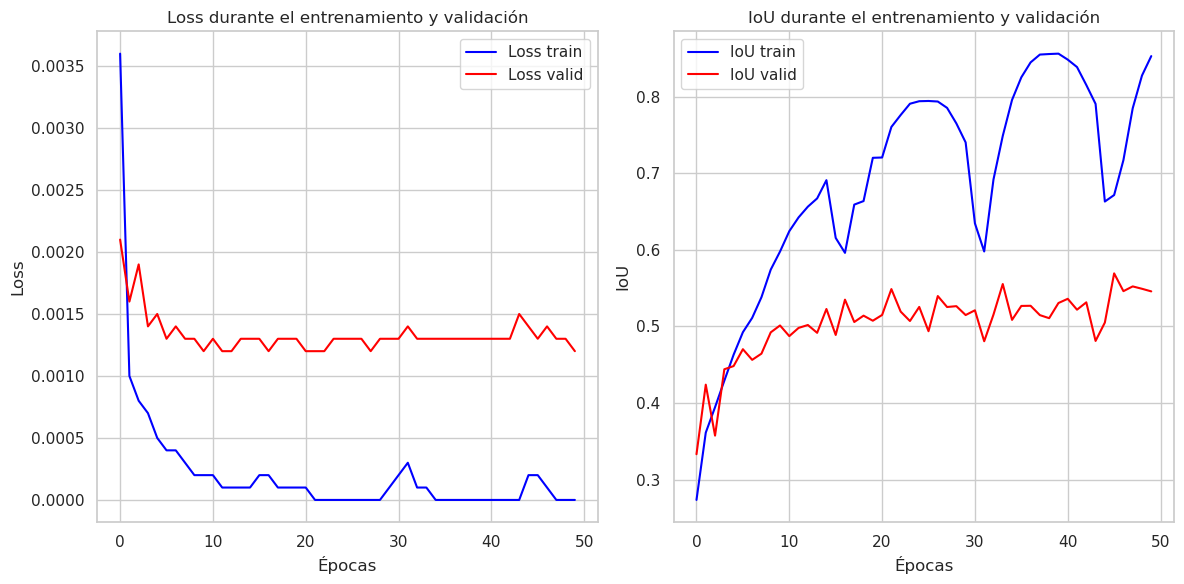

End of training!
-------------------- FINAL RESULTS ------------------------
|     - Test loss:     0.0009147908910000188                         |
|     - Test IoU: 0.4369805485426865                         |
-----------------------------------------------------------


In [73]:
trainer.show_results(train_results, save_img=True, img_name=RESULTS_IMG)